In [1]:
import requests
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

/Users/yiwenwang/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/yiwenwang/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/var/folders/vs/qmmj9bnd3f7bg_7lq_wv135r0000gn/T/ipykernel_77910/2513813552.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        


In [2]:


def tick_to_price(tick, decimals0, decimals1):
    return 1.0001 ** - tick * (10 ** (decimals1 - decimals0))

def fetch_uniswap_swaps(pool_address, total_nb_swaps, limit=1000):
    endpoint = "https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v3"
    query = """
    query MyQuery($pool: String!, $first: Int!, $skip: Int!) {
      swaps(
        where: {pool: $pool}
        orderBy: timestamp
        orderDirection: desc
        first: $first
        skip: $skip
      ) {
        amount0
        amount1
        amountUSD
        origin
        tick
        sqrtPriceX96
        sender
        recipient
        timestamp
        recipient
        id
        sqrtPriceX96
        tick
        token1 {
          decimals
          symbol
        }
        token0 {
          decimals
          symbol
        }
        transaction {
          gasUsed
          gasPrice
          blockNumber
          timestamp
        }
      }
    }
    """

    swaps = []
    skip = 0

    while len(pd.DataFrame(swaps)) < total_nb_swaps:
        variables = {"pool": pool_address, "first": limit, "skip": skip}
        response = requests.post(endpoint, json={'query': query, 'variables': variables})
        try:
            data = response.json()['data']['swaps']
        except:
            pass
        swaps.extend(data)
        skip += limit
        
    df = pd.DataFrame(swaps)
    
    df[['amount0', 'amount1', 'amountUSD', 'timestamp']] = df[['amount0', 'amount1', 'amountUSD', 'timestamp']].astype('float')
    df[['sender', 'recipient', 'origin']] = df[['sender', 'recipient', 'origin']].astype('str')

    df['gasUsed']  = df['transaction'].apply(lambda x: x['gasUsed']).astype('int')
    df['gasPrice_gwei'] = df['transaction'].apply(lambda x: x['gasPrice']).astype('int')
    df['gasPrice_eth'] = df['gasPrice_gwei']*10**-18
    
    df['blockNumber'] = df['transaction'].apply(lambda x: x['blockNumber']).astype('int')
    #df['timestamp'] = df['transaction'].apply(lambda x: x['timestamp']).astype('int')
    
    df['symbol0'] = df['token0'].apply(lambda x: x['symbol']).astype('str')
    df['symbol1'] = df['token1'].apply(lambda x: x['symbol']).astype('str')

    df['decimal0'] = df['token0'].apply(lambda x: x['decimals']).astype('int')
    df['decimal1'] = df['token1'].apply(lambda x: x['decimals']).astype('int')

    df['tick']  = df['tick'].astype('int')
    df['price'] = df.apply(lambda row: tick_to_price(row['tick'], row['decimal0'], row['decimal1']), axis=1)

    df['tcost_usd'] = df['gasPrice_eth']*df['price']*df['gasUsed']
    
    df['time'] = pd.to_datetime(df['timestamp'], unit='s')

    df = df.drop(['token1', 'token0', 'tick', 'decimal0', 'decimal1', 'id', 'transaction'], axis=1)
    
    df = df.set_index('time')
    
    path = df.iloc[0].symbol1 + '_' + df.iloc[0].symbol0 + '_pool_swap-' + str(df.index[0].date()) + '_' + str(df.index[-1].date()) + '.pkl'

    return df

In [40]:
pool_address = "0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640"
df = fetch_uniswap_swaps(pool_address, total_nb_swaps=10000)
df.head()

,amount0,amount1,amountUSD,origin,sqrtPriceX96,sender,recipient,timestamp,gasUsed,gasPrice_gwei,gasPrice_eth,blockNumber,symbol0,symbol1,volume0,volume1,price,tcost_usd
time,,,,,,,,,,,,,,,,,,
2024-02-17 06:12:11,-10443.518250,3.750000,10449.021596,0x5f0b85d2c131b0e27e2304f569e2756aa9988c8d,1500958415703232502065569401915619,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.708150e+09,544625,16844255369,1.684426e-08,19245719,USDC,WETH,6.948880e+11,4.291980e+08,2786.400853,25.561891
2024-02-17 06:10:59,49375.000000,-17.713232,49378.623703,0xb36ce3f521a1ff4b0cffb82ddd71f0a51fcf56ce,1500920686840536191295130075046168,0x51c72848c68a965f66fa7a88855f9f7784502a7f,0x51c72848c68a965f66fa7a88855f9f7784502a7f,1.708150e+09,153027,22467315387,2.246732e-08,19245713,USDC,WETH,6.948880e+11,4.291980e+08,2786.679493,9.580899
2024-02-17 06:10:35,1680.885809,-0.603090,1681.112427,0x14b30b46ec4fa1a993806bd5dda4195c5a82353e,1501098989353207113832202006285336,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.708150e+09,275706,17830511177,1.783051e-08,19245711,USDC,WETH,6.948880e+11,4.291980e+08,2785.843657,13.695149
2024-02-17 06:10:11,-1113.732629,0.400000,1114.440978,0xc7a83a8b66883ba0b97da7ea50193fb9a4f6ea67,1501105060097089189335743661009498,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.708150e+09,226010,16538106104,1.653811e-08,19245709,USDC,WETH,6.948880e+11,4.291980e+08,2785.843657,10.412863
2024-02-17 06:09:59,-15022.500000,5.395161,15031.762388,0x000461a73d3985eef4923655782aa5d0de75c111,1501101035685068249520230132810090,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.708150e+09,299655,16996752324,1.699675e-08,19245708,USDC,WETH,6.948880e+11,4.291980e+08,2785.843657,14.188753


In [7]:
# those can be considered non arbitrager possibly 
# cause they need to go through the app ui to swap and there is no possibility to select whos the receiver address

print('Percent of pure guys :',round(len(df[df.sender == df.recipient])*100/len(df), 4), '%')

Percent of pure guys : 63.57 %


In [ ]:
print(df.iloc[0].origin)
print(df.iloc[0].sender)

0x571baf09da284998c49a1d19bd1e9bd6386b9f55
0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad


In [ ]:
print('Percent of unique origines :',round(len(df.origin.unique())*100/len(df), 4), '%')
print('Percent of unique senders  :',round(len(df.sender.unique())*100/len(df), 4), '%')
print('Percent of unique recipient:',round(len(df.recipient.unique())*100/len(df), 4), '%')

Percent of unique origines : 36.39 %
Percent of unique senders  : 1.1 %
Percent of unique recipient: 10.82 %


# Dynamic fee algorithm

"token1": {
          "decimals": "18",
          "symbol": "WETH"
        },
"token0": {
  "decimals": "6",
  "symbol": "USDC"
},

amount0: how many of USDC the pool received during this swap 

amount1: how many of WETH the pool received during this swap

if amount1 is positive, it means the pool received a sell order of WETH.

if amount1 is negative, it means the pool received a buy order of WETH.

In [120]:
df['tcost_usd'] = df['tcost_usd'] + df['amountUSD'] * 0.05/100

In [125]:
df = df.drop_duplicates()

In [123]:
(df[df['tcost_usd']>1000]['tcost_usd']/df[df['tcost_usd']>1000]['amountUSD']).describe()

count    5.000000
mean     0.111522
std      0.150286
min      0.001711
25%      0.026400
50%      0.048570
75%      0.110421
max      0.370510
dtype: float64

In [8]:
df_reversed = df.iloc[::-1]
df_reversed.head()

,amount0,amount1,amountUSD,origin,sqrtPriceX96,sender,recipient,timestamp,gasUsed,gasPrice_gwei,gasPrice_eth,blockNumber,symbol0,symbol1,volume0,volume1,price,tcost_usd
time,,,,,,,,,,,,,,,,,,
2024-02-16 04:02:47,1722.869818,-0.604538,1722.936923,0x9686d4cbed835e06344dd1604aa5aa12c70944d7,1484474343416459302172614734352018,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x0e304f5b7d89597f841631ba752f6dea55e6b095,1.708056e+09,464358,19819637771,1.981964e-08,19237961,USDC,WETH,6.948873e+11,4.291965e+08,2848.662658,26.217403
2024-02-16 04:03:35,-2066.928325,0.725991,2068.044083,0xb981045f185150fac7e961a9a31bab5bcee6123d,1484482342307840326691076672878597,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0xb981045f185150fac7e961a9a31bab5bcee6123d,1.708056e+09,326359,20425911757,2.042591e-08,19237965,USDC,WETH,6.948873e+11,4.291965e+08,2848.662658,18.989698
2024-02-16 04:03:47,-939.517274,0.330000,940.028125,0x66b32796622d7326b8e158710d076b0eab55575f,1484485978213081791069579504941036,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.708056e+09,261860,20476416645,2.047642e-08,19237966,USDC,WETH,6.948873e+11,4.291965e+08,2848.662658,15.274399
2024-02-16 04:04:11,-1112.474742,0.390752,1113.082615,0x7ff41ecd5db04431753d46e1b0873b9be2c97b5a,1484490283481852229527029779178463,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0x4d4136796365fc8905269e42ee6448b67b4bcd49,1.708056e+09,495710,23632480176,2.363248e-08,19237968,USDC,WETH,6.948873e+11,4.291965e+08,2848.662658,33.371675
2024-02-16 04:04:11,-63.000734,0.022129,63.035255,0x98f7cdfce177a9090bf99abc6720a3e47a7537ae,1484490527294959742915430202131622,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0xdef1c0ded9bec7f1a1670819833240f027b25eff,1.708056e+09,226539,21633480176,2.163348e-08,19237968,USDC,WETH,6.948873e+11,4.291965e+08,2848.662658,13.960803


In [ ]:
df.groupby('blockNumber').mean()['tcost_usd'].rolling(50).mean().plot()
plt.title('Price of the swap')
plt.show()

Text(0, 0.5, 'Volume')

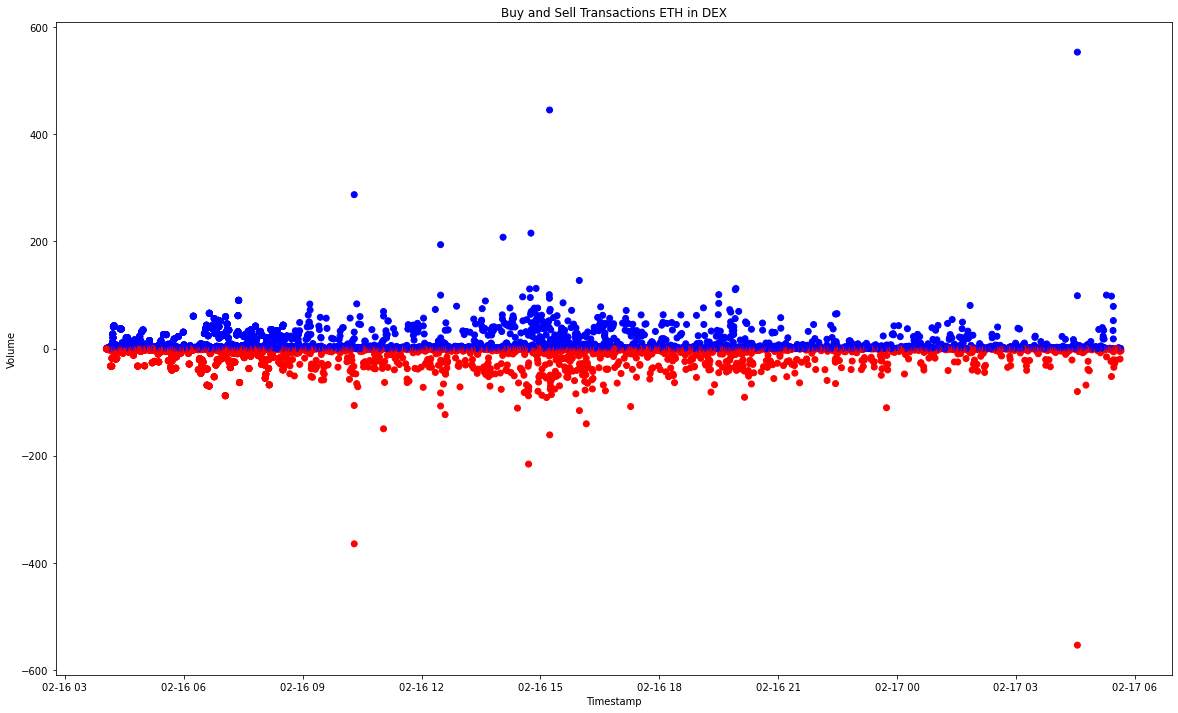

In [32]:
# Assign colors based on buy/sell
colors = np.where(df['amount1'] > 0, 'blue', 'red')

# Plot scatter plot
plt.figure(figsize=(20,12))
plt.scatter(df.index, df['amount1'], c=colors)
plt.title('Buy and Sell Transactions ETH in DEX')
plt.xlabel('Timestamp')
plt.ylabel('Volume')

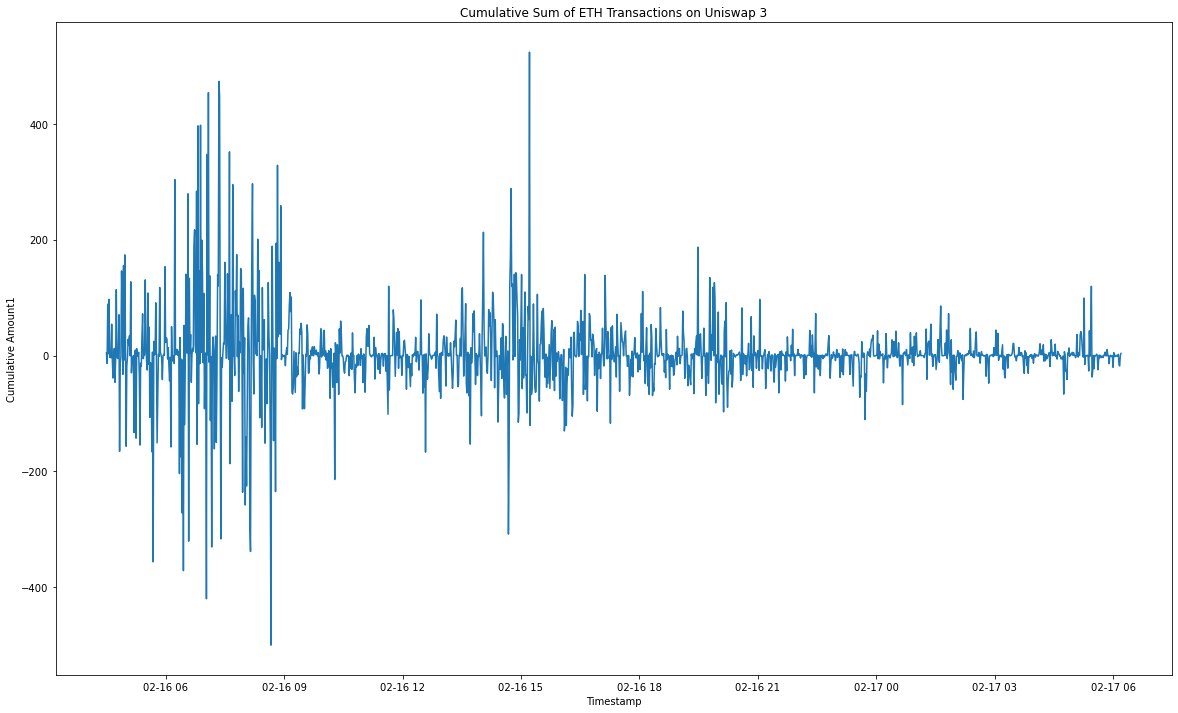

In [41]:
df_minute = df['amount1'].groupby(pd.Grouper(freq='1Min')).sum()
# Plot line plot for cumulative sum
plt.figure(figsize=(20,12))
plt.plot(df_minute)
plt.title('Cumulative Sum of ETH Transactions on Uniswap 3')
plt.xlabel('Timestamp')
plt.ylabel('Cumulative Amount1')
plt.show()

In [42]:
vol_punished, vol_total = 0, 0
bid_punished, ask_punished = 0, 0
dynamic_fees = [0]

# equal_punish_fee_constant c
c = 0.05

# iterate in natural time order 
for i in range(1, len(df_reversed)):
    row = df_reversed.iloc[i]
    # trade moves in the same direction
    if np.sign(row['amount1']) == np.sign(df_reversed['amount1'].iloc[i - 1]):
        vol_punished += np.abs(row['amount1'])
        dynamic_fees.append(row['tcost_usd'] * c)
        if row['amount1'] > 0:
            bid_punished += row['tcost_usd'] * c
        else:
            ask_punished += row['tcost_usd'] * c
    else:
        dynamic_fees.append(0)
    vol_total += np.abs(row['amount1'])
    
print(f"{(vol_punished/vol_total*100):.4f}% of the volumn will be punished by dynamic fees, resulting in {(sum(dynamic_fees)):.4f} extra fees to the LP.")
print(f"{bid_punished:.4f} are from bid; and {ask_punished:.4f} are from ask")

47.5911% of the volumn will be punished by dynamic fees, resulting in 9003.2277 extra fees to the LP.
5510.4564 are from bid; and 3492.7712 are from ask


## change the constant based on Volumn and Volatility? 

In [53]:
# trading size of arbitrageursin ETH
total_volume, num_trade = 0, 0
for arbitrageur in df.sender.unique():
    print(arbitrageur)
    total_volume += df.loc[df['sender'] == arbitrageur, 'volume1'].sum()
    num_trade += df.loc[df['sender'] == arbitrageur, 'volume1'].count()
    
print(f'average trading size of arbitrageurs per swap is {(total_volume/num_trade):.4f}')

0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad
0x1111111254eeb25477b68fb85ed929f73a960582
0xdef1c0ded9bec7f1a1670819833240f027b25eff
0xa69babef1ca67a37ffaf7a485dfff3382056e78c
0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
0xe37e799d5077682fa0a244d46e5649f71457bd09
0xf3de3c0d654fda23dad170f0f320a92172509127
0xe8cfad4c75a5e1caf939fd80afcf837dde340a69
0xf081470f5c6fbccf48cc4e5b82dd926409dcdd67
0xe592427a0aece92de3edee1f18e0157c05861564
0x7174b67526dafb2dd1d6daabf3b5783c7090d15c
0x03f911aedc25c770e701b8f563e8102cfacd62c0
0x5c9321e92ba4eb43f2901c4952358e132163a85a
0x3face0004bc1003b9d0672e7b23134cb80115fb6
0xdea6fdea0471ce1545331b7b93fdbd43786fa4c2
0x6f1cdbbb4d53d226cf4b917bf768b94acbab6168
0x00000000032962b51589768828ad878876299e14
0x2deae6ce94d65ac1de19a1fc4bb160c4e02c92ef
0xd129d8c12f0e7aa51157d9e6cc3f7ece2dc84ecd
0xbc2c6cd5013585ac720160efcb1feced30837177
0xd19dc09880685dd8cf60687d57936358582876b5
0x767c8bb1574bee5d4fe35e27e0003c89d43c5121
0x00000000009e50a7ddb7a7b0e2ee6604fd120e49
0x5079fc00f

In [53]:
cex = pd.read_pickle('./data/binance_ethusdc-2024-01-01_2024_01_31.pkl')
cex.set_index('time', inplace=True)
cex.price

time
2024-01-01 00:00:03.953    2281.65
2024-01-01 00:00:12.961    2281.38
2024-01-01 00:00:12.961    2281.19
2024-01-01 00:00:12.962    2281.19
2024-01-01 00:00:12.962    2281.19
                            ...   
2024-01-31 23:58:46.318    2281.43
2024-01-31 23:58:46.380    2281.43
2024-01-31 23:59:01.498    2281.49
2024-01-31 23:59:08.297    2281.51
2024-01-31 23:59:26.240    2281.56
Name: price, Length: 786022, dtype: float64

In [87]:
cex['log_return']= cex['price'].pct_change().apply(lambda x: np.log(1+x))

In [88]:
cex.head()

,trade ID,price,qty,base_qty,is_buyer_maker,log_price,log_return
time,,,,,,,
2024-01-01 00:00:03.953,33165689,2281.65,0.0888,202.610520,False,7.732654,NaN
2024-01-01 00:00:12.961,33165690,2281.38,0.0060,13.688280,True,7.732536,-0.000118
2024-01-01 00:00:12.961,33165691,2281.19,1.0789,2461.175891,True,7.732453,-0.000083
2024-01-01 00:00:12.962,33165692,2281.19,0.1851,422.248269,True,7.732453,0.000000
2024-01-01 00:00:12.962,33165693,2281.19,0.5748,1311.228012,True,7.732453,0.000000


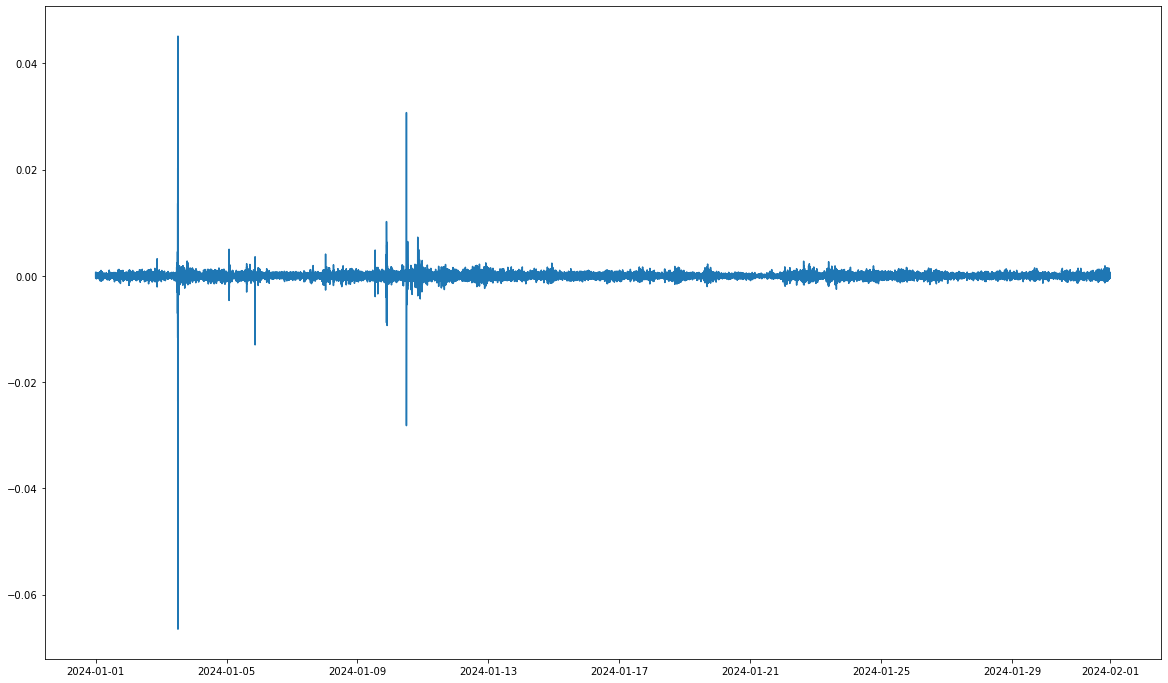

In [89]:
plt.figure(figsize=(20,12))
plt.plot(cex['log_return'])
plt.show()

In [94]:
print(f"Montly Volatility on log return is {np.std(cex['log_return'], ddof=1)*100}%")


Montly Volatility on log return is 0.026471810263608966%


In [101]:
# Calculate hourly volatility
hourly_volatility = cex['log_return'].resample('1H').std(ddof=1)

# Display the result
print(hourly_volatility)

time
2024-01-01 00:00:00    0.000110
2024-01-01 01:00:00    0.000101
2024-01-01 02:00:00    0.000113
2024-01-01 03:00:00    0.000139
2024-01-01 04:00:00    0.000117
                         ...   
2024-01-31 19:00:00    0.000209
2024-01-31 20:00:00    0.000208
2024-01-31 21:00:00    0.000196
2024-01-31 22:00:00    0.000185
2024-01-31 23:00:00    0.000163
Freq: h, Name: log_return, Length: 744, dtype: float64


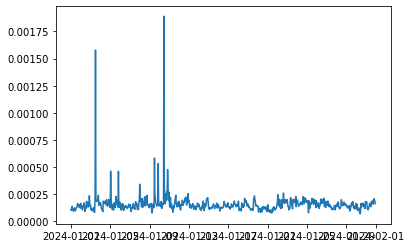

In [102]:
plt.plot(hourly_volatility)

In [103]:
hourly_volatility.describe()

count    744.000000
mean       0.000157
std        0.000094
min        0.000069
25%        0.000126
50%        0.000146
75%        0.000170
max        0.001890
Name: log_return, dtype: float64

In [145]:
# delta_p is a series
# f_buy and f_sell are in bps
def calculate_dynamic_fees(delta_p, f_min, f_max, w):
    n = len(delta_p)
    f_buy = [f_min]*n
    f_sell = [f_min]*n
    f_sigmoid = [f_min]*n

    for i in range(n):
        # f_buy increase when delta_p increases positively
        f_buy[i] = min(f_max, f_buy[i] + w * max(0, delta_p.iloc[i]))
        # f_sell increase when delta_p increases negatively
        f_sell[i] = min(f_max, f_sell[i] - w * min(0, delta_p.iloc[i]))

        f_sigmoid[i] = min(f_max, f_sell[i] - sigmoid(w * min(0, delta_p.iloc[i])))

    fees = pd.DataFrame({'f_buy': f_buy, 'f_sell':f_sell})
    return fees

    


In [214]:
import numpy as np
def sigmoid(x):
    return 0.1/(1+np.exp(-x/0.1)) + 0.01

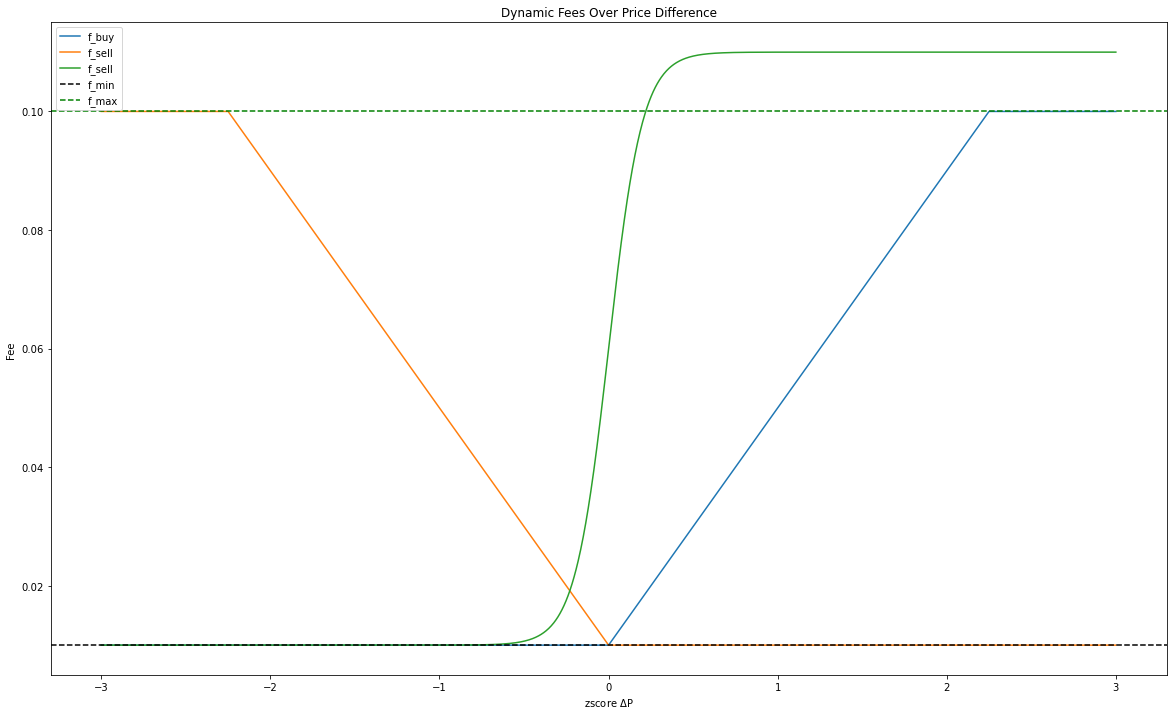

In [215]:
delta_p = pd.DataFrame({'delta_p': np.linspace(-3, 3, 2001)})

# Set parameters
f_min_value = 0.01
f_max_value = 0.1
w_value = 0.04

# Call the function
fees_result = calculate_dynamic_fees(delta_p['delta_p'], f_min_value, f_max_value, w_value)

# Plot f_buy and f_sell
plt.figure(figsize=(20,12))
plt.plot(np.linspace(-3, 3, 2001), fees_result['f_buy'].values, label='f_buy')
plt.plot(np.linspace(-3, 3, 2001), fees_result['f_sell'].values, label='f_sell')
plt.plot(np.linspace(-3, 3, 2001), sigmoid(np.linspace(-3, 3, 2001)),  label='f_sell')
# Add horizontal lines for f_min and f_max
plt.axhline(y=f_min_value, color='black', linestyle='--', label='f_min')
plt.axhline(y=f_max_value, color='g', linestyle='--', label='f_max')

plt.xlabel('zscore $\Delta$P')
plt.ylabel('Fee ')
plt.legend()
plt.title('Dynamic Fees Over Price Difference')
plt.show()